In [1]:
import pyarrow.feather as feather
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import requests
import os
import concurrent.futures
import multiprocessing
import tensorflow as tf

In [2]:
df = feather.read_feather('data/artsy_full.feather')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27577 entries, 0 to 27576
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    27577 non-null  object 
 1   slug                  27577 non-null  object 
 2   title                 27576 non-null  object 
 3   category              27576 non-null  object 
 4   medium                27575 non-null  object 
 5   date                  27577 non-null  object 
 6   iconicity             27577 non-null  float64
 7   sold                  27577 non-null  bool   
 8   image_versions        27469 non-null  object 
 9   dimensions_height_in  14120 non-null  float64
 10  dimensions_width_in   13607 non-null  float64
 11  dimensions_depth_in   836 non-null    float64
 12  permalink             27577 non-null  object 
 13  api_link              27577 non-null  object 
 14  thumb_link            26482 non-null  object 
 15  image_link         

In [4]:
df.dropna(subset=['image_versions'], inplace=True)

In [5]:
def convert_to_list(value):
    value = value.tolist()
    
    return value

def get_largest_version(row):
    
    image_versions = row['image_versions']
    
    if 'large' in image_versions:
        version = 'large'
    elif 'medium' in image_versions:
        version = 'medium'
    else:
        version = image_versions[0]
    
    row['main_image_version'] = version
    
    return row
    
df['image_versions'] = df['image_versions'].apply(convert_to_list)
df = df.apply(get_largest_version, axis=1)

In [6]:
df.category.unique()

array(['Painting', 'Sculpture', 'Drawing, Collage or other Work on Paper',
       'Photography', 'Design/Decorative Art', 'Print', 'Mixed Media',
       'Architecture', 'Textile Arts', 'Posters', 'Other', None,
       'Books and Portfolios', '', 'Fashion Design and Wearable Art',
       'Jewelry'], dtype=object)

In [7]:
df = df[df['category'] == 'Painting']

In [31]:
df = df[df['iconicity'] < df['iconicity'].mean()+3*df['iconicity'].std()]

In [33]:
df['iconicity'].describe()

count    2280.000000
mean       31.031268
std        20.995676
min        12.449186
25%        14.073435
50%        30.341327
75%        35.312171
max       170.265298
Name: iconicity, dtype: float64

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

transform = PowerTransformer()

X = df.drop(columns=['iconicity'])
y = np.log(df['iconicity'])


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [35]:
X_train.reset_index(inplace=True)
# y_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True)
# y_val.reset_index(inplace=True, drop=True)

In [36]:
class ImageDownloader:
    
    def __init__(self):
        pass
        
    def download(self, df, subset_string):
        self.df = df
        self.subset_string = subset_string
        self.bad_link = []
        
        try:
            path = './images'
            os.mkdir(path)
        except:
            pass
        try:
            os.mkdir(path+'/'+subset_string)
        except:
            pass
        try:
            os.mkdir(path+'/'+subset_string+'/0')
        except:
            pass
        
        
        self.image_dir = path+'/'+subset_string

        max_threads = 15
        threads = min(max_threads, len(df))

        indexes = df.index

        with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
            executor.map(self._download_imgs_for_set, indexes)
            
        return self
            
    def _download_imgs_for_set(self, index):

        row = self.df.iloc[index]
        filename = f'{str(index).zfill(5)}.jpg'
        path = f'images/{self.subset_string}/0/{filename}'

        img_data = requests.get(row.image_link.replace('{image_version}', row.main_image_version))
        if img_data.ok:
            with open(path, 'wb') as handler:
                handler.write(img_data.content)
        else:
            self.bad_link.append(index)
        
        
            
            

In [37]:
train_downloader = ImageDownloader()
train_downloader.download(X_train, 'train')
val_downloader = ImageDownloader()
val_downloader.download(X_val, 'val')

In [38]:
train_downloader.image_dir

'./images/train'

In [39]:
len(os.listdir('./images/train/0'))

1824

In [40]:
len(y_train)

1824

In [59]:
batch_size = 32
img_width = 224
img_height = 224

train_ds = tf.keras.utils.image_dataset_from_directory(directory=train_downloader.image_dir,
                                                       labels=list(y_train), validation_split=0.2,
                                                       subset='training',
                                                       seed=42,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                      shuffle=False)

val_ds = tf.keras.utils.image_dataset_from_directory(directory=val_downloader.image_dir,
                                                     labels=list(y_val), validation_split=0.2,
                                                     subset='validation',
                                                     seed=42,
                                                     image_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                    shuffle=False)

Found 1824 files belonging to 1 classes.
Using 1460 files for training.
Found 456 files belonging to 1 classes.
Using 91 files for validation.


In [60]:
for elem in train_ds.take(1):
    test = elem

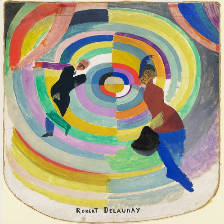

In [61]:
tf.keras.utils.array_to_img(test[0][0])

In [62]:
test[1][0]

<tf.Tensor: shape=(), dtype=float32, numpy=3.7281163>

In [63]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE).repeat()
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE).repeat()

In [64]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

In [65]:


model = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten(),
    Dense(units=4096,activation="relu"),
    Dense(units=4096,activation="relu"),
    Dense(units=1)
])

model_simple = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten(),
    Dense(units=4096,activation="relu"),
    Dense(units=1)
])

In [66]:
import warnings
warnings.filterwarnings("ignore")

In [67]:
steps_per_epoch = 1504//batch_size

validation_steps = 94//batch_size
print(steps_per_epoch)

47


In [68]:
validation_steps

2

In [75]:
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001)
model_simple.compile(optimizer=opt, loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(), tfa.metrics.RSquare()])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

early = EarlyStopping(monitor='val_root_mean_squared_error', min_delta=0, patience=20, verbose=1, mode='auto')
history = model_simple.fit(train_ds.repeat(), steps_per_epoch=steps_per_epoch, epochs=100, validation_data=val_ds, validation_steps=validation_steps, callbacks=[early, cp_callback], verbose=2,)

Epoch 1/100


2022-08-02 22:53:35.280488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-02 22:56:45.601149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 - 193s - loss: 25.7314 - root_mean_squared_error: 5.0726 - r_square: -9.0178e+01 - val_loss: 1.5685 - val_root_mean_squared_error: 1.2524 - val_r_square: -4.9753e+00 - 193s/epoch - 4s/step
Epoch 2/100
47/47 - 196s - loss: 0.7293 - root_mean_squared_error: 0.8540 - r_square: -1.6271e+00 - val_loss: 0.6318 - val_root_mean_squared_error: 0.7948 - val_r_square: -1.4067e+00 - 196s/epoch - 4s/step
Epoch 3/100
47/47 - 194s - loss: 0.5915 - root_mean_squared_error: 0.7691 - r_square: -1.1302e+00 - val_loss: 0.8240 - val_root_mean_squared_error: 0.9077 - val_r_square: -2.1390e+00 - 194s/epoch - 4s/step
Epoch 4/100

Epoch 4: saving model to training_2/cp-0004.ckpt
47/47 - 199s - loss: 0.4718 - root_mean_squared_error: 0.6869 - r_square: -7.0018e-01 - val_loss: 0.4545 - val_root_mean_squared_error: 0.6741 - val_r_square: -7.3133e-01 - 199s/epoch - 4s/step
Epoch 5/100
47/47 - 193s - loss: 0.3690 - root_mean_squared_error: 0.6075 - r_square: -3.2713e-01 - val_loss: 0.3566 - val_root_mean_squa

KeyboardInterrupt: 

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

img = image.load_img("./images/train/0/10583.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
transform.inverse_transform(model.predict(img))

In [ ]:
transform.inverse_transform(model.predict(train_ds.take(1)))

In [ ]:
transform.inverse_transform(test[0][1])

In [ ]:
test = [elem for elem in train_ds.take(1)]
transform.inverse_transform(test[0][1]) - transform.inverse_transform(model.predict(train_ds.take(1)))